In [134]:
import os
import numpy as np 

from plot_params import * 
from math import sqrt
from tqdm import tqdm
from joblib import Parallel, delayed
from scipy.stats import qmc, shapiro, norm, f, bartlett, levene, truncnorm

In [135]:
# define global functions

def check_inside_mandlebrot(i, c):
    z = 0 + 0j
    for _ in range(i):
        z = z ** 2 + c
        if abs(z) > 2:
            return 0
    return 1

def mandlebrot_area(i, s, sampling_function):
    random_complex_numbers = sampling_function(s)
    in_mandlebrot = 0
    for z in random_complex_numbers:
        in_mandlebrot += check_inside_mandlebrot(i, z)
    area = in_mandlebrot / s * area_box
    return area

def uniform_samples(n):
    real = np.random.uniform(real_min, real_max, size=n)
    imaginary = np.random.uniform(imag_min, imag_max, size=n) * 1j
    random_complex_numbers = real + imaginary
    return random_complex_numbers


def get_truncated_normal(mean, std, low, upp, size):
    return truncnorm((low - mean) / std, (upp - mean) / std, loc=mean, scale=std).rvs(size)

def importance_sampling(n):
    real = np.random.uniform(real_min, real_max, size=n)
    imaginary = get_truncated_normal(0, 1, imag_min, imag_max, size=n) * 1j
    random_complex_numbers = real + imaginary
    return random_complex_numbers

def OLHC_samples(n):
    M = int(np.sqrt(n))
    scale = 4/n
    x = np.zeros(shape=(M,M))
    y = np.zeros(shape=(M,M))
    m = 0
    samples = np.zeros(M ** 2,dtype=np.complex_)
    for i in range(M):
        for j in range(M):
            m = m + 1
            x[i,j] = m
            y[i,j] = m
            
    for i in range(M):
        # x[:,i] = permute(x[:,i],M)
        # y[:,i] = permute(y[:,i],M)
        x[:,i] = np.random.permutation(x[:,i])
        y[:,i] = np.random.permutation(y[:,i])
 
    for i in range(M):
        for k in range(M):
            reals = -2 + scale*(x[i,k] + np.random.random(1))
            imags = -2 + scale*(y[i,k] + np.random.random(1))
            samples[M*i+k] = reals + imags*1j
    return samples
    # return samples[samples != 0]

def permute(x, N):
    for i in reversed(range(1,N-1)):
        h = x[i]
        r = np.random.randint(N)
        x[i] = x[r]
        x[r] = h
    return x

def LHC_samples(n):
    sampler = qmc.LatinHypercube(d=2)
    sample = sampler.random(n=n) 
    sample = qmc.scale(sample, [real_min, imag_min], [real_max, imag_max])
    reals = sample[:, 0]
    imags = sample[:, 1]
    samples = reals + imags * 1j
    return samples

def grid_samples(n):
    M = int(sqrt(n))
    perturb = 1e-2
    real = np.linspace(real_min, real_max, M)
    imag = np.linspace(imag_min, imag_max, M)
    rr, ii = np.meshgrid(real, imag)
    samples = (rr + 1j * ii).reshape(-1) + np.random.normal(0, perturb, M ** 2) + np.random.normal(0, perturb, M ** 2) * 1j 
    return samples

def f_test(data_X, data_Y):
    '''H0: var(x)=var(y).
    returns the p value of the test
    if p > significance level, then H0 is accepted
    this test is sensitive to data_x and data_y '''
    var_x = np.var(data_X)
    var_y = np.var(data_Y)
    n_x = len(data_X)
    n_y = len(data_Y)
    if var_x/var_y > var_y/var_x:
        f_stat = var_x/var_y
        df1 = n_x - 1
        df2 = n_y - 1
    else:
        f_stat = var_y/var_x
        df1 = n_y - 1
        df2 = n_x - 1
    p_value = f.sf(f_stat, df1, df2)
    return p_value


In [136]:
# see how fast the area converges based on the number of iterations
# TODO: account for importance sampling

class Convergence():
    def __init__(self, max_i, max_s, n_runs, rand_num_generator):
        self.max_i = max_i
        self.max_s = max_s
        self.n_runs = n_runs
        self.rand_num_generator = rand_num_generator
        self.areas = 0
        self.max_mean, self.max_std = self.determine_area(max_i, max_s)
        # self.min_mean, self.min_std = self.determine_area(min_i, min_s)
        self.means = []
        self.stds = []
        print(f'best estimate: {self.max_mean} ± {self.max_std} with i = {max_i}, s = {max_s}')

    def determine_area(self, i, s):
        areas = Parallel(n_jobs=n_cores)(delayed(mandlebrot_area)(i, s, self.rand_num_generator) for _ in range(self.n_runs))
        areas = np.array(areas)
        if rand_num_generator.__name__ == 'importance_sampling':
            areas = areas / 2
            pass # do something to correct the area
        self.areas = areas
        mean = areas.mean()
        var = ((areas - mean) ** 2).sum() / (self.n_runs - 1)
        std = sqrt(var)
        return mean, std
    
    def diff_with_max(self, i, s):
        mean, std = self.determine_area(i, s)
        mean_diff = mean - self.max_mean
        std_diff = std + self.max_std
        return mean_diff, std_diff

In [137]:
# sampling area
real_min = -2
real_max = 2
imag_min = -2
imag_max = 2
area_box = (real_max - real_min) * (imag_max - imag_min)

# settings 
n_cores = os.cpu_count()
n_runs = 25
min_i = 10
max_i = 20
n_different_i = 15
min_s = 1000
max_s = 3000
n_different_s = 15

# lists for looping
i_values = np.linspace(max_i, min_i, n_different_i, dtype=int)
s_values = np.linspace(sqrt(max_s), sqrt(min_s), n_different_s, dtype=int) ** 2

stds_s = np.zeros(n_different_s)
means_i = np.zeros(n_different_i)
stds_i = np.zeros(n_different_i)

areas_min_all_results = []
areas_max_all_results = []
stds_s_all_results = []
means_i_all_results = []
stds_i_all_results = []


In [138]:
# # visual checks of the integrity of the sampling functions

# sampling_fuctions = [uniform_samples, LHC_samples, OLHC_samples, grid_samples]
# colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

# fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
# plt.suptitle('Samples')
# for ax, samp, color in zip(axs.ravel(), sampling_fuctions, colors):
#     samples = samp(1440)
#     ax.scatter(np.real(samples),np.imag(samples), s=1, color=color)
#     ax.set(title=samp.__name__)

# fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
# plt.suptitle('Real values')
# for ax, samp, color in zip(axs.ravel(), sampling_fuctions, colors):
#     samples = samp(1440)
#     sns.histplot(np.real(samples), bins=20, color=color, ax=ax)
#     ax.set(title=samp.__name__)

# fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
# plt.suptitle('Imaginary values')
# for ax, samp, color in zip(axs.ravel(), sampling_fuctions, colors):
#     samples = samp(1440)
#     sns.histplot(np.imag(samples), bins=20, color=color, ax=ax)
#     ax.set(title=samp.__name__)

In [139]:
sampling_fuctions = [uniform_samples, LHC_samples, OLHC_samples, grid_samples, importance_sampling]
for rand_num_generator in sampling_fuctions:

    stds_s = np.zeros(n_different_s)
    means_i = np.zeros(n_different_i)
    stds_i = np.zeros(n_different_i)

    con = Convergence(max_i, max_s, n_runs, rand_num_generator)
    areas_max = con.areas
    areas_max_all_results.append(areas_max)

    con.determine_area(min_i, min_s)
    areas_min = con.areas
    areas_min_all_results.append(areas_min)

    for m in tqdm(range(n_different_s), desc=rand_num_generator.__name__ + ' s convergence'):
        s = s_values[m]
        _, stds_s[m] = con.determine_area(min_i, s)

    for m in tqdm(range(n_different_i), desc=rand_num_generator.__name__ + ' i convergence'):
        i = i_values[m]
        means_i[m], stds_i[m] = con.diff_with_max(i, max_s)

    stds_s_all_results.append(stds_s)
    means_i_all_results.append(means_i)
    stds_i_all_results.append(stds_i)

best estimate: 1.7619200000000002 ± 0.07700897494592575 with i = 20, s = 3000


uniform_samples i convergence: 100%|██████████| 15/15 [00:00<00:00, 16.55it/s]


best estimate: 1.725226666666667 ± 0.06187432902741326 with i = 20, s = 3000


LHC_samples i convergence: 100%|██████████| 15/15 [00:00<00:00, 16.71it/s]


best estimate: 1.78816 ± 0.07630768127929337 with i = 20, s = 3000


OLHC_samples i convergence: 100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


best estimate: 1.6294399999999998 ± 0.015481984751699342 with i = 20, s = 3000


grid_samples i convergence: 100%|██████████| 15/15 [00:00<00:00, 16.55it/s]


best estimate: 1.3614933333333332 ± 0.06130956061025247 with i = 20, s = 3000


importance_sampling i convergence: 100%|██████████| 15/15 [00:01<00:00, 12.91it/s]


Uniform is NOT normal distributed with p=0.04252226650714874
Latin hypercube is normal distributed with p=0.4131457209587097
Orthogonal is normal distributed with p=0.4026607871055603
Grid is normal distributed with p=0.08020472526550293
Importance sampling is normal distributed with p=0.9849861860275269


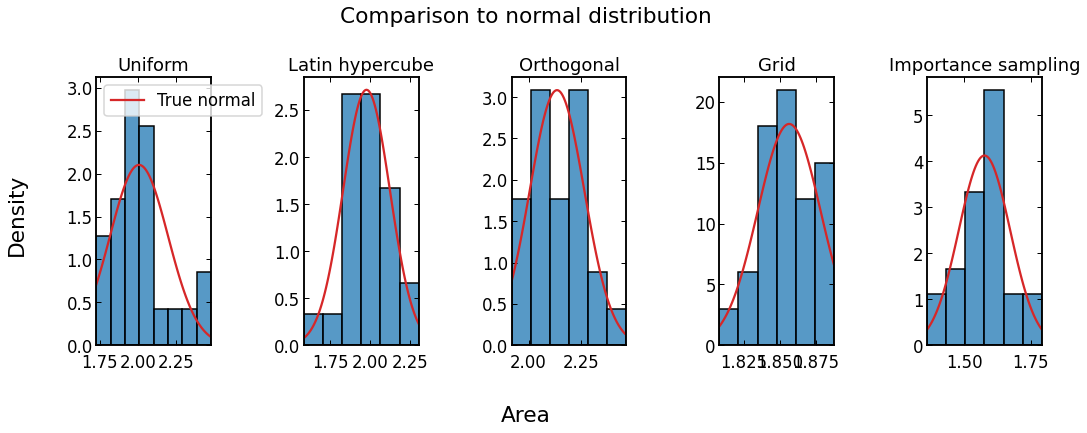

In [140]:
# plot to see if uniform distributed

sampling_names = ['Uniform', 'Latin hypercube', 'Orthogonal', 'Grid', 'Importance sampling']
fig, axs = plt.subplots(1, 5, figsize=(15, 6))
plt.suptitle('Comparison to normal distribution')
fig.supxlabel('Area')
fig.supylabel('Density')

for ax, areas, name in zip(axs, areas_min_all_results, sampling_names):
    x = np.linspace(min(areas), max(areas), 100)
    y = norm.pdf(x, areas.mean(), areas.std())
    ax.plot(x, y, label='True normal', color='tab:red')
    ax.set(xlim=(min(areas), max(areas)), ylabel=' ', title=name)
    sns.histplot(areas, stat='density', ax=ax)

    stat, p = shapiro(areas)
    if p > 0.05:
        print(f'{name} is normal distributed with p={p}')
    else:
        print(f'{name} is NOT normal distributed with p={p}')

axs[0].legend(loc=2)
axs[0].set_title('Uniform')
axs[1].set_title('Latin hypercube')
axs[2].set_title('Orthogonal')
fig.tight_layout()
plt.show()

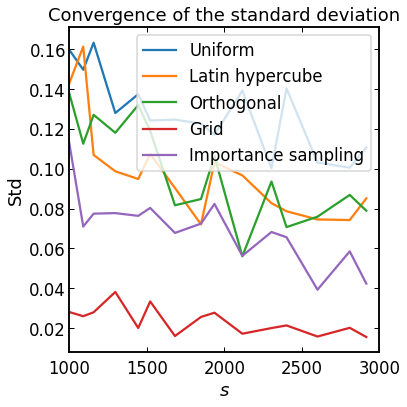

In [141]:
# plots showing the convergence of the std

for stds, name in zip(stds_s_all_results, sampling_names):
    plt.plot(s_values, stds, label=name)
plt.legend(loc=1)
plt.title('Convergence of the standard deviation')
plt.ylabel('Std')
plt.xlabel('$s$')
plt.xlim(min_s, max_s)
plt.tight_layout()
plt.savefig('std_conv.pdf')
plt.show()

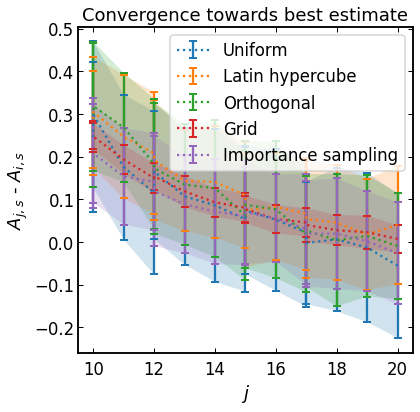

In [142]:
# plot shwoing the convegence towards the best estimate of the area

for means, stds, name in zip(means_i_all_results, stds_i_all_results, sampling_names):
    plt.errorbar(i_values, means, stds, fmt=':', capsize=4, capthick=2, label=name)
    plt.fill_between(i_values, means - stds, means + stds, alpha=0.2)
plt.legend()
plt.title('Convergence towards best estimate')
plt.xlabel('$j$')
plt.ylabel('$A_{j, s}$ - $A_{i, s}$')
plt.savefig('area_conv.pdf')
plt.show()

In [143]:
# determine 95% confidence interval
Z_value = 1.96
for areas, samp in zip(areas_max_all_results, sampling_fuctions):
    sample_mean = np.mean(areas)
    sample_std = np.std(areas, ddof=1)
    num_samples = len(areas)
    interval = 2 * Z_value * sample_std / sqrt(num_samples)
    print(f'95% confidence gives range {sample_mean} ± {interval} using {samp.__name__}')

95% confidence gives range 1.7619200000000002 ± 0.060375036357605785 using uniform_samples
95% confidence gives range 1.725226666666667 ± 0.04850947395749199 using LHC_samples
95% confidence gives range 1.78816 ± 0.059825222122966 using OLHC_samples
95% confidence gives range 1.6294399999999998 ± 0.012137876045332284 using grid_samples
95% confidence gives range 1.3614933333333332 ± 0.04806669551843794 using importance_sampling


In [144]:
# stat tests to see if the variances differ significantly
# TODO: test the remaining pairs

alpha = 0.05
p_uniform_lhc = f_test(areas_max_all_results[0], areas_max_all_results[1])
p_uniform_o = f_test(areas_max_all_results[0], areas_max_all_results[2])
p_lhc_o = f_test(areas_max_all_results[1], areas_max_all_results[2])

if p_uniform_lhc > alpha:
    print(f'Uniform and LHC have same variance with p = {p_uniform_lhc}')
else:
    print(f'Uniform and LHC do NOT have same variance with p = {p_uniform_lhc}')

if p_uniform_o > alpha:
    print(f'Uniform and Ortogonal have same variance with p = {p_uniform_o}')
else:
    print(f'Uniform and Ortogonal do NOT have same variance with p = {p_uniform_o}')

if p_lhc_o > alpha:
    print(f'LHC and Ortogonal have same variance with p = {p_lhc_o}')
else:
    print(f'LHC and Ortogonal do NOT have same variance with p = {p_lhc_o}')

Uniform and LHC have same variance with p = 0.14531758902265665
Uniform and Ortogonal have same variance with p = 0.4823114869510021
LHC and Ortogonal have same variance with p = 0.15556089719762226


In [145]:
# # same with bartlett

# _, p_uniform_lhc = bartlett(areas_max_all_results[0], areas_max_all_results[1])
# _, p_uniform_o = bartlett(areas_max_all_results[0], areas_max_all_results[2])
# _, p_lhc_o = bartlett(areas_max_all_results[1], areas_max_all_results[2])

# if p_uniform_lhc > alpha:
#     print(f'Uniform and LHC have same variance with p = {p_uniform_lhc}')
# else:
#     print(f'Uniform and LHC do NOT have same variance with p = {p_uniform_lhc}')

# if p_uniform_o > alpha:
#     print(f'Uniform and Ortogonal have same variance with p = {p_uniform_o}')
# else:
#     print(f'Uniform and Ortogonal do NOT have same variance with p = {p_uniform_o}')

# if p_lhc_o > alpha:
#     print(f'LHC and Ortogonal have same variance with p = {p_lhc_o}')
# else:
#     print(f'LHC and Ortogonal do NOT have same variance with p = {p_lhc_o}')


In [146]:
# # same with levene

# _, p_uniform_lhc = levene(areas_max_all_results[0], areas_max_all_results[1])
# _, p_uniform_o = levene(areas_max_all_results[0], areas_max_all_results[2])
# _, p_lhc_o = levene(areas_max_all_results[1], areas_max_all_results[2])

# if p_uniform_lhc > alpha:
#     print(f'Uniform and LHC have same variance with p = {p_uniform_lhc}')
# else:
#     print(f'Uniform and LHC do NOT have same variance with p = {p_uniform_lhc}')

# if p_uniform_o > alpha:
#     print(f'Uniform and Ortogonal have same variance with p = {p_uniform_o}')
# else:
#     print(f'Uniform and Ortogonal do NOT have same variance with p = {p_uniform_o}')

# if p_lhc_o > alpha:
#     print(f'LHC and Ortogonal have same variance with p = {p_lhc_o}')
# else:
#     print(f'LHC and Ortogonal do NOT have same variance with p = {p_lhc_o}')
